In [25]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

import patsy

In [26]:
test_df = pd.read_csv('classification_challenge_submission.csv')
test_df.head()

,Unnamed: 0,age,type_employer,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country
0,18099,45,Federal-gov,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,20,United-States
1,10672,17,Private,12th,8,Never-married,Sales,Own-child,White,Male,0,0,40,United-States
2,17947,24,Private,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States
3,13753,46,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Black,Male,4064,0,40,United-States
4,4279,59,Private,Bachelors,13,Separated,Adm-clerical,Unmarried,White,Male,0,0,60,United-States


In [27]:
df = pd.read_csv('classification_challenge_training.csv') # read in the census-derived data; mind the separator
df.head()

,Unnamed: 0,age,type_employer,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income
0,4,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
1,14656,32,Private,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,1
2,26677,29,Private,10th,6,Married-spouse-absent,Adm-clerical,Unmarried,White,Female,0,0,40,Mexico,0
3,4281,30,Private,Assoc-voc,11,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,Mexico,0
4,15668,66,Private,HS-grad,9,Widowed,Priv-house-serv,Not-in-family,White,Female,0,0,8,United-States,0


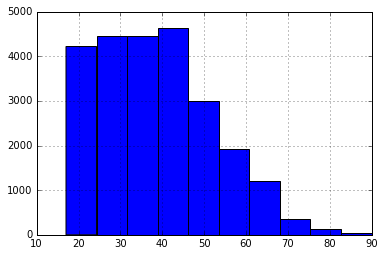

In [28]:
df.age.hist()

In [29]:
df.describe()

,Unnamed: 0,age,education_num,capital_gain,capital_loss,hr_per_week,income
count,24420.000000,24420.000000,24420.000000,24420.000000,24420.000000,24420.000000,24420.000000
mean,16328.315807,38.546683,10.072686,1068.968428,86.702621,40.490909,0.240008
std,9409.140597,13.640007,2.569242,7376.793336,402.449980,12.323059,0.427097
min,1.000000,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,8181.500000,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,16373.500000,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,24494.250000,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,32561.000000,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [30]:
test_df['income'] = 2

In [31]:
combined = pd.concat([df,test_df])

In [32]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 8140
Data columns (total 15 columns):
Unnamed: 0       32561 non-null int64
age              32561 non-null int64
type_employer    32561 non-null object
education        32561 non-null object
education_num    32561 non-null int64
marital          32561 non-null object
occupation       32561 non-null object
relationship     32561 non-null object
race             32561 non-null object
sex              32561 non-null object
capital_gain     32561 non-null int64
capital_loss     32561 non-null int64
hr_per_week      32561 non-null int64
country          32561 non-null object
income           32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 4.0+ MB


In [33]:
def get_features(dataframe):
    features = patsy.dmatrix('~ C(type_employer) + C(marital) +\
    C(occupation) + C(relationship) + C(race) + C(sex) + C(country)', dataframe)
    X_df = pd.DataFrame(features, columns=features.design_info.column_names)
    X_df.drop('Intercept', axis=1, inplace=True)
    #X_df = pd.concat([X_df, dataframe[['age', 'education_num', 'capital_gain', 'capital_loss', 'hr_per_week']]], axis=1)
    return X_df

In [34]:
df.shape

(24420, 15)

In [35]:
num_X = combined[['Unnamed: 0','income', 'age', 'education_num', 'capital_gain', 'capital_loss', 'hr_per_week']]

In [36]:
all_X = get_features(combined)

In [37]:
all_X.shape

(32561, 79)

In [38]:
all_X.reset_index(drop=True, inplace=True)

In [39]:
num_X.reset_index(drop=True, inplace=True)

In [40]:
full_df = pd.concat([num_X, all_X], axis=1)

In [41]:
submission_df = full_df.copy()
submission_df = submission_df[submission_df['income']==2]

In [42]:
training_df = full_df.copy()
training_df = training_df[training_df['income']!=2]

In [43]:
training_df.head()

,Unnamed: 0,income,age,education_num,capital_gain,capital_loss,hr_per_week,C(type_employer)[T.Federal-gov],C(type_employer)[T.Local-gov],C(type_employer)[T.Never-worked],...,C(country)[T.Portugal],C(country)[T.Puerto-Rico],C(country)[T.Scotland],C(country)[T.South],C(country)[T.Taiwan],C(country)[T.Thailand],C(country)[T.Trinadad&Tobago],C(country)[T.United-States],C(country)[T.Vietnam],C(country)[T.Yugoslavia]
0,4,0,53,7,0,0,40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,14656,1,32,9,0,0,40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,26677,0,29,6,0,0,40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4281,0,30,11,0,0,40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15668,0,66,9,0,0,8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [57]:
X = training_df.iloc[:,2:]

In [58]:
X.head()

,age,education_num,capital_gain,capital_loss,hr_per_week,C(type_employer)[T.Federal-gov],C(type_employer)[T.Local-gov],C(type_employer)[T.Never-worked],C(type_employer)[T.Private],C(type_employer)[T.Self-emp-inc],...,C(country)[T.Portugal],C(country)[T.Puerto-Rico],C(country)[T.Scotland],C(country)[T.South],C(country)[T.Taiwan],C(country)[T.Thailand],C(country)[T.Trinadad&Tobago],C(country)[T.United-States],C(country)[T.Vietnam],C(country)[T.Yugoslavia]
0,53,7,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,32,9,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29,6,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30,11,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,66,9,0,0,8,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
y = training_df['income']

In [60]:
"""Clean/munge your data."""

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=77) ## create train-test out of the data given

In [61]:
lr = LogisticRegressionCV(Cs=10, cv=5)
lr.fit(X,y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [62]:
""" Fit a binary classification predictor."""

y_pred = lr.predict(X_test)
y_score = lr.decision_function(X_test) # Submit these response, the output of model.decision_function

           predicted_over50k  predicted_under50k
over_50k                1142                 792
under_50k                417                5708
             precision    recall  f1-score   support

          0       0.88      0.93      0.90      6125
          1       0.73      0.59      0.65      1934

avg / total       0.84      0.85      0.84      8059



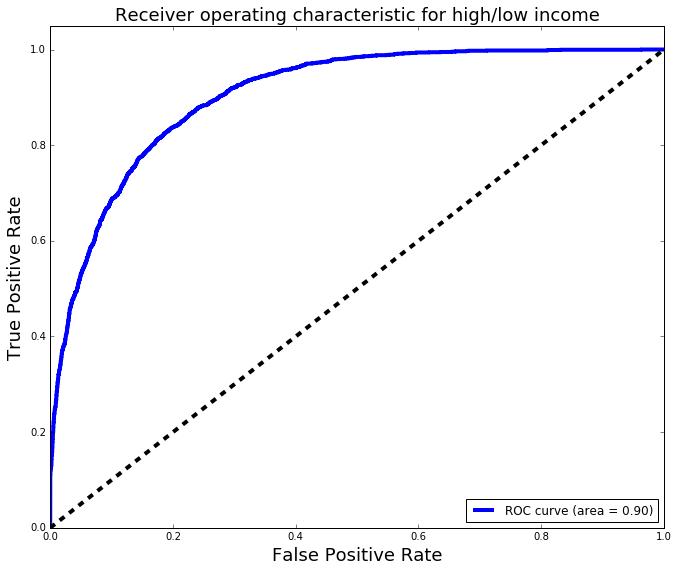

In [63]:
""" Check your performance so far."""

conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over_50k', 'under_50k'],
                            columns=['predicted_over50k','predicted_under50k'])

print(confusion)
print classification_report(Y_test,y_pred)
roc_auc_score(Y_test, y_score)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [64]:
coef = pd.DataFrame([X.columns.values.tolist(), lr.coef_[0].tolist()], index=['features', 'coef']).T

In [65]:
coef.sort_values(by='coef', ascending=False)

,features,coef
14,C(marital)[T.Married-civ-spouse],0.955691
22,C(occupation)[T.Exec-managerial],0.849787
37,C(relationship)[T.Wife],0.797883
31,C(occupation)[T.Tech-support],0.625906
28,C(occupation)[T.Prof-specialty],0.622206
42,C(sex)[T.Male],0.524019
5,C(type_employer)[T.Federal-gov],0.484305
29,C(occupation)[T.Protective-serv],0.467233
30,C(occupation)[T.Sales],0.324219
1,education_num,0.239393


In [66]:
X_sub = submission_df.iloc[:,2:]
y_sub = lr.decision_function(X_sub)

In [67]:
y_sub

array([-0.97296719, -4.65049108, -3.66091827, ...,  0.98944014,
        0.59502162,  1.56673007])

In [68]:
from sklearn.grid_search import GridSearchCV
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']


gs = GridSearchCV(LogisticRegression(solver='liblinear'),
                 {'C': C_vals,
                 'penalty': penalties},
                 cv=10)
gs.fit(X_train,Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [69]:
gs.best_estimator_

LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
gs.best_score_

0.8536153046879775

In [71]:
""" Fit a binary classification predictor."""

y_pred2 = gs.predict(X_test)
y_score2 = gs.decision_function(X_test) # Submit these response, the output of model.decision_function

           predicted_over50k  predicted_under50k
over_50k                1152                 782
under_50k                417                5708
             precision    recall  f1-score   support

          0       0.88      0.93      0.90      6125
          1       0.73      0.60      0.66      1934

avg / total       0.84      0.85      0.85      8059



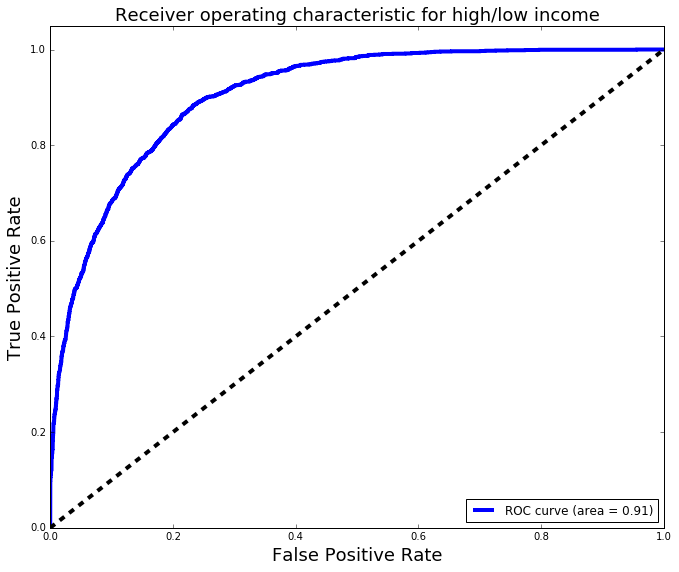

In [72]:
""" Check your performance so far."""

conmat = np.array(confusion_matrix(Y_test, y_pred2, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over_50k', 'under_50k'],
                            columns=['predicted_over50k','predicted_under50k'])

print(confusion)
print classification_report(Y_test,y_pred2)
roc_auc_score(Y_test, y_score2)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score2)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [73]:
coef = pd.DataFrame([X.columns.values.tolist(), gs.best_estimator_.coef_[0].tolist()], index=['features', 'coef']).T

In [74]:
coef.sort_values(by='coef', ascending=False)

,features,coef
14,C(marital)[T.Married-civ-spouse],1.53194
37,C(relationship)[T.Wife],1.32278
22,C(occupation)[T.Exec-managerial],1.07705
31,C(occupation)[T.Tech-support],0.980408
42,C(sex)[T.Male],0.847581
28,C(occupation)[T.Prof-specialty],0.805244
29,C(occupation)[T.Protective-serv],0.802214
5,C(type_employer)[T.Federal-gov],0.737526
30,C(occupation)[T.Sales],0.568866
72,C(country)[T.Philippines],0.395285


In [ ]:
submission_df.drop('income', axis=1, inplace=True)

In [77]:
submission_df.head()

,Unnamed: 0,age,education_num,capital_gain,capital_loss,hr_per_week,C(type_employer)[T.Federal-gov],C(type_employer)[T.Local-gov],C(type_employer)[T.Never-worked],C(type_employer)[T.Private],...,C(country)[T.Portugal],C(country)[T.Puerto-Rico],C(country)[T.Scotland],C(country)[T.South],C(country)[T.Taiwan],C(country)[T.Thailand],C(country)[T.Trinadad&Tobago],C(country)[T.United-States],C(country)[T.Vietnam],C(country)[T.Yugoslavia]
24420,18099,45,10,0,0,20,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24421,10672,17,8,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24422,17947,24,13,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24423,13753,46,9,4064,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24424,4279,59,13,0,0,60,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [80]:
submission_df['income'] = gs.predict(X_sub)
submission_df['score'] = gs.decision_function(X_sub)

In [81]:
submission_df.head()

,Unnamed: 0,age,education_num,capital_gain,capital_loss,hr_per_week,C(type_employer)[T.Federal-gov],C(type_employer)[T.Local-gov],C(type_employer)[T.Never-worked],C(type_employer)[T.Private],...,C(country)[T.Scotland],C(country)[T.South],C(country)[T.Taiwan],C(country)[T.Thailand],C(country)[T.Trinadad&Tobago],C(country)[T.United-States],C(country)[T.Vietnam],C(country)[T.Yugoslavia],income,score
24420,18099,45,10,0,0,20,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,-0.987497
24421,10672,17,8,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,-4.908774
24422,17947,24,13,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,-3.652702
24423,13753,46,9,4064,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.200643
24424,4279,59,13,0,0,60,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,-0.744930


In [82]:
submission_df.to_csv('classification_submission_amer_peter_jesse_jocelyn.csv')

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
gs2 = GridSearchCV(RandomForestClassifier(min_samples_leaf=10),
                  {'n_estimators': np.arange(10,50,10),
                  'max_features': np.arange(1,5,1)},
                  cv=10)
gs2.fit(X_train,Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([10, 20, 30, 40]), 'max_features': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [87]:
gs2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [93]:
y_pred2 = gs2.predict_proba(X_test)

In [94]:
y_pred2

array([[ 0.71631956,  0.28368044],
       [ 0.84346156,  0.15653844],
       [ 0.92948532,  0.07051468],
       ..., 
       [ 0.90279815,  0.09720185],
       [ 0.87161806,  0.12838194],
       [ 0.68740287,  0.31259713]])

In [97]:
rfy = pd.DataFrame(y_pred2)

In [100]:
rfy['actual'] = np.array(Y_test)

In [101]:
rfy.head()

,0,1,actual
0,0.716320,0.283680,0
1,0.843462,0.156538,0
2,0.929485,0.070515,0
3,0.940889,0.059111,0
4,0.951407,0.048593,0


In [103]:
rfy['threshold-50'] = rfy[1].map(lambda x: 0 if x < 0.5 else 1)

In [105]:
rfy.head(20)

,0,1,actual,threshold-50
0,0.716320,0.283680,0,0
1,0.843462,0.156538,0,0
2,0.929485,0.070515,0,0
3,0.940889,0.059111,0,0
4,0.951407,0.048593,0,0
5,0.715581,0.284419,0,0
6,0.387306,0.612694,1,1
7,0.494727,0.505273,1,1
8,0.864731,0.135269,0,0
9,0.865924,0.134076,0,0


In [106]:
roc_auc_score(Y_test, rfy[1])

0.9064791591921153

           predicted_over50k  predicted_under50k
over_50k                 721                1213
under_50k                105                6020
             precision    recall  f1-score   support

          0       0.83      0.98      0.90      6125
          1       0.87      0.37      0.52      1934

avg / total       0.84      0.84      0.81      8059



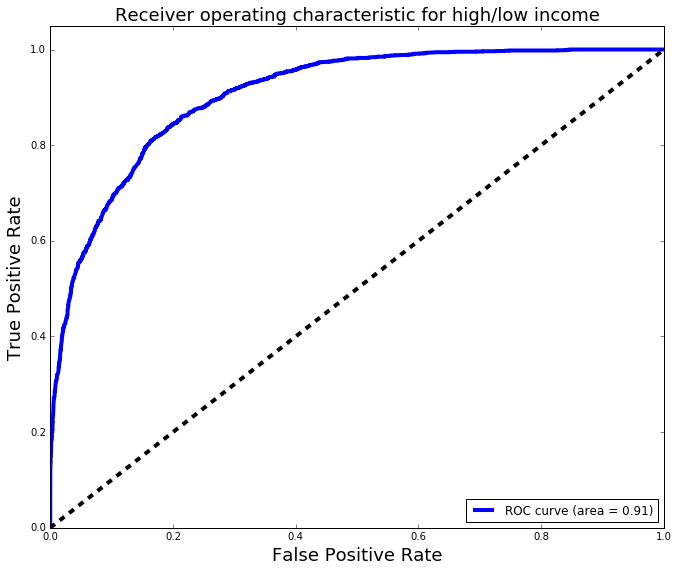

In [107]:
""" Check your performance so far."""

conmat = np.array(confusion_matrix(Y_test, rfy['threshold-50'], labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over_50k', 'under_50k'],
                            columns=['predicted_over50k','predicted_under50k'])

print(confusion)
print classification_report(Y_test,rfy['threshold-50'])
roc_auc_score(Y_test, rfy[1])

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, rfy[1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()